<a href="https://colab.research.google.com/github/zp20945/DSDM/blob/main/assignment/Image_segmentation_CE888_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import required libraries
import os
import random
import numpy as np
from tqdm import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout, Lambda
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam


In [ ]:
# initialization of variable
config_segmentation = {"batch_size": 16, 'Save_Model': False, 'Epochs': 3, "TrainingPlot": False,
                       "train_set_ratio": 0.85, "val_set_ratio": 0.15, "num_class": 3, "CHANNELS": 3}


In [ ]:
# define size
segmentation_new_size = {'width': 128, 'height': 128}

In [ ]:
# define model
def model_unet_kaggle(img_hieght, img_width, img_channel, num_classes):
    inputs = Input((128, 128, 3))
    s = Lambda(lambda x: x / 255)(inputs)

    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c5)

    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

In [ ]:
# initialization of required parameters
batch_size = config_segmentation.get('batch_size')
img_size = (segmentation_new_size.get("width"), segmentation_new_size.get("height"))
img_width = img_size[0]
img_height = img_size[1]
epochs = config_segmentation.get('Epochs')
img_channels = config_segmentation.get('CHANNELS')
num_classes = config_segmentation.get("num_class")

In [ ]:
# give path to load dataset
dir_images = "D:/ce888/Images"
dir_masks = "D:/ce888/Masks"

## give the local path where the data is stored.

In [ ]:
# load images dataset
allfiles_image = sorted(
[
  os.path.join(dir_images, fname)
  for fname in tqdm(os.listdir(dir_images))
  if fname.endswith(".jpg")
]
)


100%|███████████████████████████████████| 2003/2003 [00:00<00:00, 64098.45it/s]


In [ ]:
# load mask images
allfiles_mask = sorted(
[
  os.path.join(dir_masks, fname)
  for fname in tqdm(os.listdir(dir_masks))
    if fname.endswith(".png") and not fname.startswith(".")
]
)


100%|███████████████████████████████████| 2003/2003 [00:00<00:00, 46240.68it/s]


In [ ]:

print("Number of samples:", len(allfiles_image))
for input_path, target_path in tqdm(zip(allfiles_image[:10], allfiles_mask[:10])):
  print(input_path, "|", target_path)
total_samples = len(allfiles_mask)

10it [00:00, 454.26it/s]

Number of samples: 2003
D:/ce888/Images\image_0.jpg | D:/ce888/Masks\image_0.png
D:/ce888/Images\image_1.jpg | D:/ce888/Masks\image_1.png
D:/ce888/Images\image_10.jpg | D:/ce888/Masks\image_10.png
D:/ce888/Images\image_100.jpg | D:/ce888/Masks\image_100.png
D:/ce888/Images\image_1000.jpg | D:/ce888/Masks\image_1000.png
D:/ce888/Images\image_1001.jpg | D:/ce888/Masks\image_1001.png
D:/ce888/Images\image_1002.jpg | D:/ce888/Masks\image_1002.png
D:/ce888/Images\image_1003.jpg | D:/ce888/Masks\image_1003.png
D:/ce888/Images\image_1004.jpg | D:/ce888/Masks\image_1004.png
D:/ce888/Images\image_1005.jpg | D:/ce888/Masks\image_1005.png


In [ ]:
# spliting of train data and test data
train_ratio = config_segmentation.get("train_set_ratio")
val_samples = int(total_samples * (1 - train_ratio))
random.Random(1337).shuffle(allfiles_image)
random.Random(1337).shuffle(allfiles_mask)
train_img_paths = allfiles_image[:-val_samples]
train_mask_paths = allfiles_mask[:-val_samples]
val_img_paths = allfiles_image[-val_samples:]
val_mask_paths = allfiles_mask[-val_samples:]


In [ ]:
# create arrays for train dataset
x_train = np.zeros((len(train_img_paths), img_height, img_width, img_channels), dtype=np.uint8)
y_train = np.zeros((len(train_mask_paths), img_height, img_width, 1), dtype=np.bool)

In [ ]:
# create arrays for test datset 
x_val = np.zeros((len(val_img_paths), img_height, img_width, img_channels), dtype=np.uint8)
y_val = np.zeros((len(val_mask_paths), img_height, img_width, 1), dtype=np.bool)


In [ ]:
# load images as a training dataset
print('\nLoading training images: ', len(train_img_paths), 'images ...')
for n, file_ in tqdm(enumerate(train_img_paths)):
  img = tf.keras.preprocessing.image.load_img(file_, target_size=img_size)
  x_train[n] = img


0it [00:00, ?it/s]


Loading training images:  1703 images ...


1703it [17:48,  1.59it/s]


In [ ]:
# load mask images as a training dataset
print('\nLoading training masks: ', len(train_mask_paths), 'masks ...')
for n, file_ in tqdm(enumerate(train_mask_paths)):
  img = tf.keras.preprocessing.image.load_img(file_, target_size=img_size, color_mode="grayscale")
  y_train[n] = np.expand_dims(img, axis=2)

0it [00:00, ?it/s]


Loading training masks:  1703 masks ...


1703it [03:37,  7.81it/s]


In [ ]:
# load images as a test dataset
print('\nLoading test images: ', len(val_img_paths), 'images ...')
for n, file_ in tqdm(enumerate(val_img_paths)):
  img = tf.keras.preprocessing.image.load_img(file_, target_size=img_size)
  x_val[n] = img


0it [00:00, ?it/s]


Loading test images:  300 images ...


300it [03:04,  1.63it/s]


In [ ]:
# load mask images as test dataset
print('\nLoading test masks: ', len(val_mask_paths), 'masks ...')
for n, file_ in tqdm(enumerate(val_mask_paths)):
  img = tf.keras.preprocessing.image.load_img(file_, target_size=img_size, color_mode="grayscale")
  y_val[n] = np.expand_dims(img, axis=-1)

0it [00:00, ?it/s]


Loading test masks:  300 masks ...


300it [00:40,  7.43it/s]


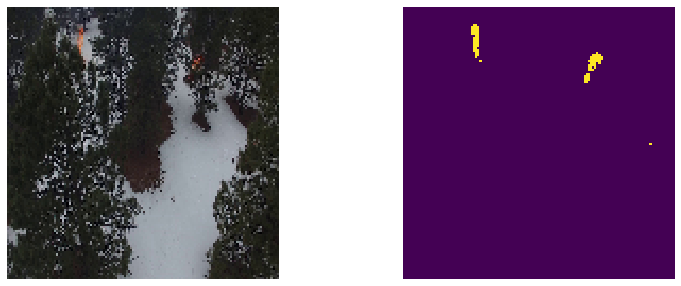

In [ ]:
# plot the data of real image and true mask 
idx_rand = random.randint(0, len(train_img_paths))
plt.figure(figsize=(13, 5))
plt.subplot(1, 2, 1)
plt.imshow(x_train[idx_rand])
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(np.squeeze(y_train[idx_rand]))
plt.axis('off')
plt.show()

tf.keras.backend.clear_session()
    
    

In [ ]:
# define metrics 
METRICS = [
    tf.keras.metrics.AUC(name='auc'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.TruePositives(name='tp'),
    tf.keras.metrics.TrueNegatives(name='tn'),
    tf.keras.metrics.FalsePositives(name='fp'),
    tf.keras.metrics.FalseNegatives(name='fn'),
    tf.keras.metrics.Accuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.MeanIoU(num_classes=2, name='iou'),
    tf.keras.metrics.BinaryAccuracy(name='bin_accuracy'),
]


In [ ]:
# call model created function 
model = model_unet_kaggle(img_height, img_width, img_channels, num_classes)
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=METRICS)


In [ ]:
# give path to store model
checkpoint_path = "D:\ce888\cp2.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

In [ ]:
# define checkpoint and early stopping
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_best_only=True)
early_stopper = tf.keras.callbacks.EarlyStopping(patience=5)

# train model for 1 epoch
results = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=1, batch_size=batch_size,
                        callbacks=[early_stopper, checkpoint])

107/107 [==============================] - 640s 5s/step - loss: 0.0843 - auc: 0.5706 - recall: 0.0229 - tp: 1587.3519 - tn: 14112888.9630 - fp: 85528.7685 - fn: 81682.9167 - accuracy: 0.0000e+00 - precision: 0.0175 - iou: 0.4971 - bin_accuracy: 0.9791 - val_loss: 0.0386 - val_auc: 0.6688 - val_recall: 0.0097 - val_tp: 268.0000 - val_tn: 4887651.0000 - val_fp: 3.0000 - val_fn: 27278.0000 - val_accuracy: 0.0000e+00 - val_precision: 0.9889 - val_iou: 0.4972 - val_bin_accuracy: 0.9944
INFO:tensorflow:Assets written to: D:\ce888\cp2.ckpt\assets


In [ ]:
# predict mask using model
model_predict = tf.keras.models.load_model(checkpoint_path)     # load model for prediction
preds_val = model.predict(x_val, verbose=1)
preds_val_t = (preds_val > 0.5).astype(np.uint8)


10/10 [==============================] - 17s 1s/step


In [ ]:
# define plot funtion to plot segmented images
from skimage.io import imshow
def plot_segmentation_test(xval, yval, ypred, num_samples):
    fig = plt.figure(figsize=(16, 13))
    for i in range(0, num_samples):
        plt.subplot(3, num_samples, (0 * num_samples) + i + 1)
        ix_val = random.randint(0, len(ypred) - 1)
        title = str(i+1)
        plt.title(title)
        imshow(xval[ix_val])
        plt.axis('off')

        plt.subplot(3, num_samples, (1 * num_samples) + i + 1)
        plt.imshow(np.squeeze(yval[ix_val]))
        plt.title('gTruth')
        plt.axis('off')

        plt.subplot(3, num_samples, (2 * num_samples) + i + 1)
        plt.imshow(tf.keras.preprocessing.image.array_to_img(ypred[ix_val]))
        plt.title('Mask')
        plt.axis('off')
    plt.subplots_adjust(wspace=0.05, hspace=0.1)


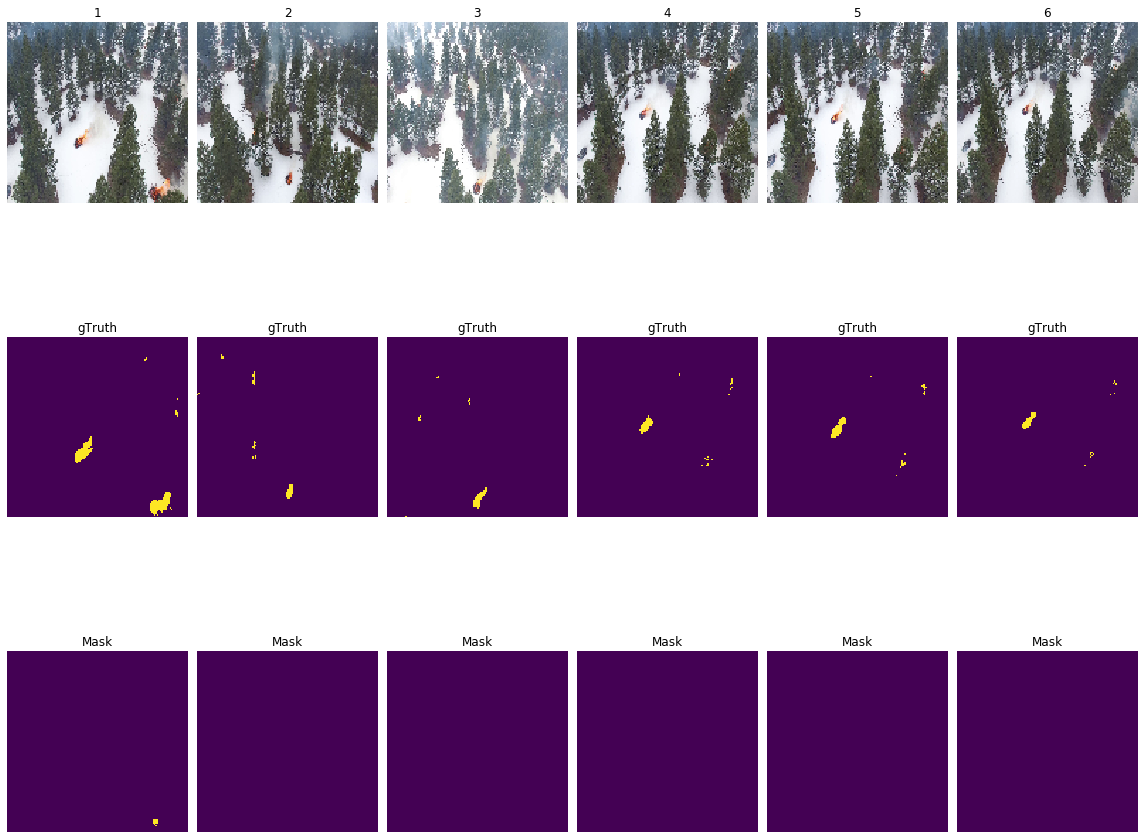

In [ ]:
# Plot image, truth_mask and predicted mask images
plot_segmentation_test(xval=x_val, yval=y_val, ypred=preds_val_t, num_samples=6)


In [ ]:
# Loads the weights
tf.keras.models.load_model(checkpoint_path)

# Re-evaluate the model
Restored_model_2 = model.evaluate(x_train, y_train, verbose=2)


54/54 - 251s - loss: 0.0417 - auc: 0.6543 - recall: 0.0091 - tp: 1494.0000 - tn: 27737568.0000 - fp: 32.0000 - fn: 162860.0000 - accuracy: 0.0000e+00 - precision: 0.9790 - iou: 0.4971 - bin_accuracy: 0.9942


In [ ]:
# Re-evaluate the model
Restored_model_1 = model.evaluate(x_val, y_val, verbose=2)

10/10 - 48s - loss: 0.0386 - auc: 0.6688 - recall: 0.0097 - tp: 268.0000 - tn: 4887651.0000 - fp: 3.0000 - fn: 27278.0000 - accuracy: 0.0000e+00 - precision: 0.9889 - iou: 0.4972 - bin_accuracy: 0.9944
